<a href="https://colab.research.google.com/github/lphohmann/DL_microbial_gene_classifier/blob/main/1D_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do: 
1. confusion matrix for test set
2. fix learn.predict() weird output

# Setting everything up

In [ ]:
%%capture
# installing fastai
!pip install fastai --upgrade

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from fastai import *
from fastai.vision.all import *
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# mount google drive to access files and set the correct working directory
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DL_project
/content/drive/MyDrive/DL_project


# Define functions required for creating the Datablock

In [ ]:
# defining transform functions required for correctly loading the data when building the DataBlock

# one hot encoding function
def OH_enc(seq: str):
    # get the categories into array
    cats = ['K', 'D', 'N', 'E', 'R', 'A', 'T', 'L', 'I', 'Q', 'C', 'F', 'G', 'W', 'M', 'S', 'H', 'P', 'V', 'Y']
    cat_array = np.array(sorted(cats), ndmin=1) #
    # get seq into array
    trunc_seq = seq[:300] # truncate sequences longer than 300 
    seq_array = np.array(list(trunc_seq))
    # one hot encode the sequence
    onehot_encoder = OneHotEncoder(categories=[cat_array],sparse=False,handle_unknown='ignore')
    onehot_encoded_seq = onehot_encoder.fit_transform(seq_array.reshape(len(seq_array), 1))
    return np.transpose(onehot_encoded_seq)

# zero padding function that makes sure the encoded sequences are all of the same format later
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

# combine in one function
def main_item_tfms(seq): 
    enc_seq = OH_enc(seq)
    pad_encseq_array = pad_along_axis(enc_seq,300,1)
    return pad_encseq_array 

In [ ]:
# functions to get x and y data
def get_y(r): return r['Knum'] # y are the labels in the Knum column in the dataframe
def get_x(r): return main_item_tfms(r['Seq']) # x are the sequences in the Seq column; the transform functinos are applied

In [ ]:
# defining the TransformBlock for single-label categorical targets to be used to apply additional transforms when building the datablock
def CategoryBlock(vocab=None, sort=True, add_na=False):
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

In [ ]:
# read in my data from which training and validation set will be created
trainval = pd.read_csv('data/trainval.csv', low_memory=False)

In [ ]:
# building the datablock, which acts as a template on how to load the data
dblock = DataBlock(blocks=(TransformBlock(batch_tfms=IntToFloatTensor), CategoryBlock()),
                   splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=trainval[['Knum']]), # stratified split the trainval df into 80% train and 20% valid set
                   get_x = get_x,
                   get_y = get_y)

# Create the dataloader

In [ ]:
# checking/debugging the datablock 
#dblock.summary(trainval)

In [ ]:
# create dataloaders from datablock 
dls = dblock.dataloaders(trainval, bs=256, shuffle=True, drop_last=True) # shuffle the data to prevent overfitting due to an organized dataset and drop the last incomplete batch

In [ ]:
# visualize batch label distribution, compare with hist after batch balance correction
x,y = dls.one_batch()
#plt.hist(y,bins=dls.c) # if run with gpu there is a type error so this has to run in a different session

In [ ]:
# access the dataset from datablock
dsets = dblock.datasets(trainval)
#dsets.train
#dsets.valid

In [ ]:
# label distribution in valid set
valid_label_count = Counter(dsets.valid.items.Knum)
#valid_label_count.most_common() # check the distribution of seqs per label

In [ ]:
# label distribution in train set
train_label_count = Counter(dsets.train.items.Knum)
#train_label_count.most_common() # check the distribution of seqs per label

In [ ]:
# calc. weights for each label class
class_weights = {} # empty dict to be filled with the class weights
for label in train_label_count:
    class_weights[label] = 1/train_label_count[label] # for every category the weight is (1 / number of associated sequences)
wgts = dsets.train.items.Knum.map(class_weights).values[:len(dsets.train)] 
weighted_dls = dblock.dataloaders(trainval,bs=256, dl_type=WeightedDL, wgts=wgts, shuffle=True, drop_last=True) 
dls.train = weighted_dls.train # replace the train dl with a weighted dl
# in the end the train dls is balanced and the valid dls is unbalanced -> later a suitable metric has to be chosen

In [ ]:
# exploring if the dls was corretly constructed - 1
# check dls attributes .c and .vocab 
#dls.vocab
#dls.c

In [ ]:
# exploring if the dls was corretly constructed - 2
# check one batch to make sure the dls is constructed right (balanced)
x,y = dls.one_batch()
#y # these should be the targets 
#x # and these the encoded sequences
# check the shape
x.shape #torch.Size([256, 20, 300])

torch.Size([256, 20, 300])

In [ ]:
# check the label distribution in the batch to see if balancing was successful, compare with the previous histogram
#x,y = dls.one_batch()
#plt.hist(y,bins=dls.c)

# Functions for the Learner

In [ ]:
# the metric 
# choose one that is also fine for unbalanced datasets such as the F1score
F1Score = F1Score(average='macro') # 'macro' calculate score for each label individually, and then find their unweighted mean. penalizes poor performance on minority classes more

In [ ]:
# callback to change the tensor type of the input to match the model weights type
class TensorTypeChange(Callback): 
    def before_batch(self):
        new_xb = [x.type(torch.FloatTensor).cuda() for x in self.learn.xb]
        self.learn.xb = new_xb
        return self.learn.xb

In [ ]:
# callback to save the model during training
smc = SaveModelCallback(monitor="f1_score", fname="1D_ResNet152", comp=np.greater, with_opt=True) # change comp based on metric

In [ ]:
# callback to stop training after x epochs when the model doesnt improve anymore
estop = EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=10) # note: change comp based on chosen metric

In [ ]:
# function to get the learner
def get_learner(m): # .to_fp16()
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), opt_func=Adam, lr=defaults.lr, cbs=[TensorTypeChange,smc,estop], metrics=[accuracy,F1Score], model_dir='models') 

# Bottleneck resnet: Book-based architecture

In [ ]:
# the resnet stem
def _resnet_stem(*sizes): 
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2, ndim=1 if i==0 else 1) for i in range(len(sizes)-1) # ndim
    ] + [nn.MaxPool1d(kernel_size=3, stride=2, padding=1)] # 1d

# test
#m = _resnet_stem(20,32,32,64) # just add 20, to add the first layer to increate to 20 channels

In [ ]:
# the conv block definition and ResBlock
def _conv_block(ni,nf,stride): 
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1, ndim=1), # ndim
        ConvLayer(nf//4, nf//4, stride=stride, ndim=1), #
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero, ndim=1)) #

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None, ndim=1) # ndim
        self.pool = noop if stride==1 else nn.AvgPool1d(2, ceil_mode=True) # changed to 1d
    
    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
# putting it all together
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(20,32,32,64) # 
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion 
        blocks = [self._make_layer(*o) for o in enumerate(layers)] 
        super().__init__(*stem, *blocks,
                        nn.AdaptiveAvgPool1d(1), Flatten(), #1d
                        nn.Linear(self.block_szs[-1], n_out))

    def _make_layer(self, idx, n_layers): 
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2] 
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers) 
        ])

In [ ]:
# defining the architecture
rn = ResNet(dls.c, [3, 8, 36, 3], 4) # this would be a resnet152
# get the learner
learn = get_learner(rn)

NameError: ignored

In [ ]:
# checking the model architecture
#learn.model

# Bottleneck resnet: Training

In [ ]:
# choose an adequate lr
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide)) 

In [ ]:
# training the model
epochs=1
lr=0.00010964782268274575 # based on valley in lr_find 
learn.fit_one_cycle(epochs, lr) #, cbs=[TensorTypeChange] # moved TensorTypeChange callback from learner to fit, potentially change it back and change cb construction

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.232764,1.982613,0.485873,0.444906,11:01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Better model found at epoch 0 with f1_score value: 0.4449060949002532.


In [ ]:
# call learn.export to save all the information of our Learner object for inference
# SaveModelCallback loads the best model at the end so the best model is exported
#learn = learn.to_fp32()
learn.export(fname='export.pkl') # to_fp32 otherwise when loading the model for inference it gives a type error

# Model evaluation on testset

In [ ]:
# slightly change the TensorTypeCallback so that the input is no longer put on gpu (as the weights arent either here)
# removed the .cuda() 
class TensorTypeChange(Callback): 
    def before_batch(self):
        new_xb = [x.type(torch.FloatTensor) for x in self.learn.xb] # removed the .cuda() 
        self.learn.xb = new_xb
        return self.learn.xb

In [ ]:
# load the learner containing the template on how to load data
learn_inf = load_learner('result_200epochs/export.pkl')

In [ ]:
# remove non required callbacks
learn_inf.remove_cbs([SaveModelCallback,EarlyStoppingCallback]) #TensorTypeChange,

In [30]:
# read in my data from which training and validation set will be created
test_df = pd.read_csv('data/test.csv', low_memory=False)

In [31]:
# create test dataloader
test_dl = learn_inf.dls.test_dl(test_df, with_labels=True) # based on dblock template

In [ ]:
# Validate on dl
validation_data = learn_inf.validate(dl=test_dl)
# print the test fscore
print("Test set Fscore:",validation_data[2])

0.42689778043463666


In [ ]:
# get predictions
# further test here to find out about the output produced by learn_inf.predict()
preds = learn_inf.get_preds(dl=test_dl)

# Validation data set confusion matrix 

In [ ]:
# change back the TensorTypeChange callback
class TensorTypeChange(Callback): 
    def before_batch(self):
        new_xb = [x.type(torch.FloatTensor).cuda() for x in self.learn.xb] # added .cuda() again
        self.learn.xb = new_xb
        return self.learn.xb

In [ ]:
# to plot the construction matrix, the learner has to be constructed without the loss function (otherwise it gives an assertion error)
def get_learner(m):
    return Learner(dls, m, opt_func=Adam, lr=defaults.lr, cbs=[TensorTypeChange,smc], metrics=[accuracy,F1Score], model_dir='models') # no loss function provided (unclear on exact cause)
# architecture
rn = ResNet(dls.c, [3, 8, 36, 3], 4) # resnet152
learn = get_learner(rn)

In [ ]:
# load the model
learn = learn.load('1D_ResNet152_fscore0.9298790322045838') # the model you want to load

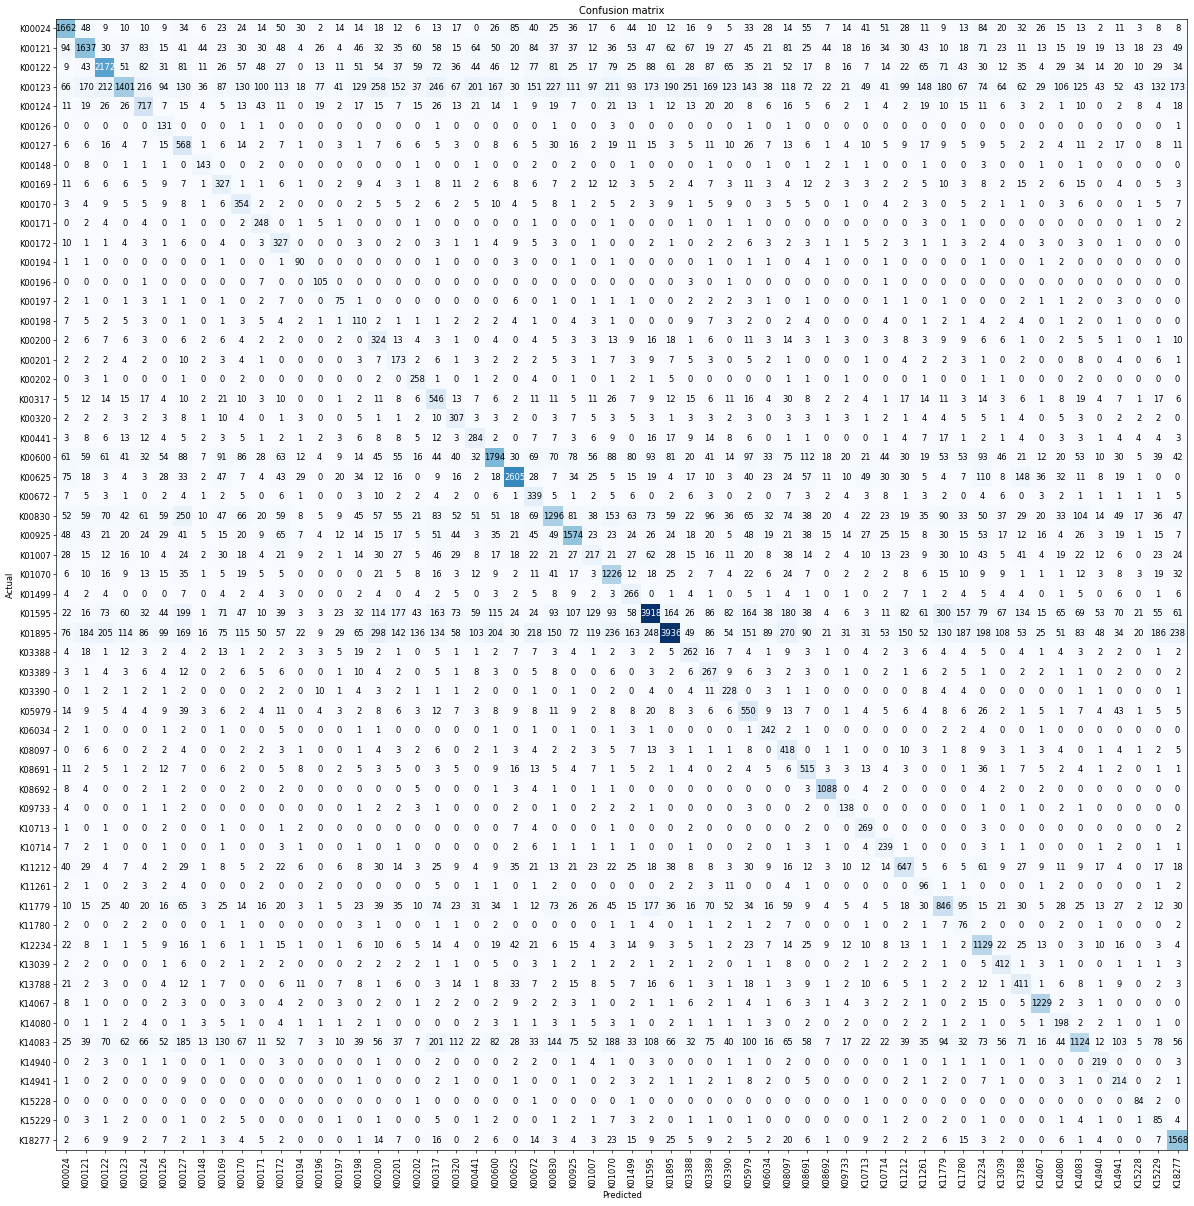

In [ ]:
# get the classification matrix
interp = ClassificationInterpretation.from_learner(learn) 
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)
plt.savefig('valid_confusion_matrix.pdf',format='pdf')

# Bottleneck resnet: Loading the model for inference

In [42]:
# change the TensorTypeChange callback so that the input isnt put on the gpu
class TensorTypeChange(Callback): 
    def before_batch(self):
        new_xb = [x.type(torch.FloatTensor) for x in self.learn.xb] # removed .cuda() again
        self.learn.xb = new_xb
        return self.learn.xb

In [41]:
# load the model for inference
learn_inf = load_learner('result_200epochs/export.pkl')

In [44]:
# test example
seq = 'AGCCCTAAAAAAAAAAAAAAAAAAAAAAAAA'
seq_array = main_item_tfms(seq)

In [45]:
# make prediction
learn_inf.predict(seq_array)#[1].argmax() # 

#returned three things: 1. the predicted category in the same format you originally provided 
#                       2. the index of the predicted category
#                       3. and the probabilities of each category
#The last two are based on the order of categories in the vocab of the DataLoaders

# in my case it return the vocab (all categories), and then twice a tensor with the predictions

("['K08097', 'K11261', 'K03390', 'K08097', 'K10714', 'K10714', 'K11212', 'K08691', 'K10713', 'K10713', 'K10714', 'K10713', 'K10714', 'K10713', 'K05979', 'K09733', 'K01895', 'K08097', 'K01895', 'K03389', 'K03390', 'K05979', 'K10714', 'K00123', 'K05979', 'K10713', 'K03390', 'K03389', 'K08691', 'K01595', 'K08691', 'K11212', 'K15228', 'K10713', 'K05979', 'K03389', 'K01007', 'K03388', 'K08097', 'K12234', 'K10714', 'K11212', 'K10713', 'K03388', 'K08691', 'K03390', 'K03389', 'K09733', 'K08692', 'K11261', 'K03390', 'K08692', 'K08097', 'K01595', 'K06034', 'K11779', 'K06034', 'K08692']",
 tensor([-21.6807, -14.9048, -24.4779, -21.2056, -16.2467, -16.1689, -15.0494,
         -20.2717, -17.5520, -17.0077, -16.6237, -17.0293, -16.5627, -17.3567,
         -23.2657, -18.8451, -27.9462, -21.9022, -27.3018, -25.4374, -24.7292,
         -23.8313, -16.6111,   3.0958, -23.4399, -17.2780, -24.8766, -25.1190,
         -20.4711, -28.1887, -20.9598, -15.3403,  -3.8072, -17.5171, -23.2829,
         -25.1309, -

# Confusion matrix on test set

In [49]:
# create dataloaders with twice the test_dl (only one will be used later for the CM)
dls = DataLoaders(test_dl,test_dl)

In [50]:
# to plot the construction matrix, the learner has to be constructed without the loss function (otherwise it gives an assertion error)
def get_learner(m):
    return Learner(dls, m, opt_func=Adam, lr=defaults.lr, cbs=[TensorTypeChange,smc], metrics=[accuracy,F1Score], model_dir='models') # no loss function provided (unclear on exact cause)
# architecture
rn = ResNet(dls.c, [3, 8, 36, 3], 4) # resnet152
learn = get_learner(rn)

In [56]:
# load the model
learn = learn.load('1D_ResNet152_fscore0.9298790322045838') # the model you want to load

In [57]:
# switch out the dataloaders to get the CM on the test set
learn.dls = dls

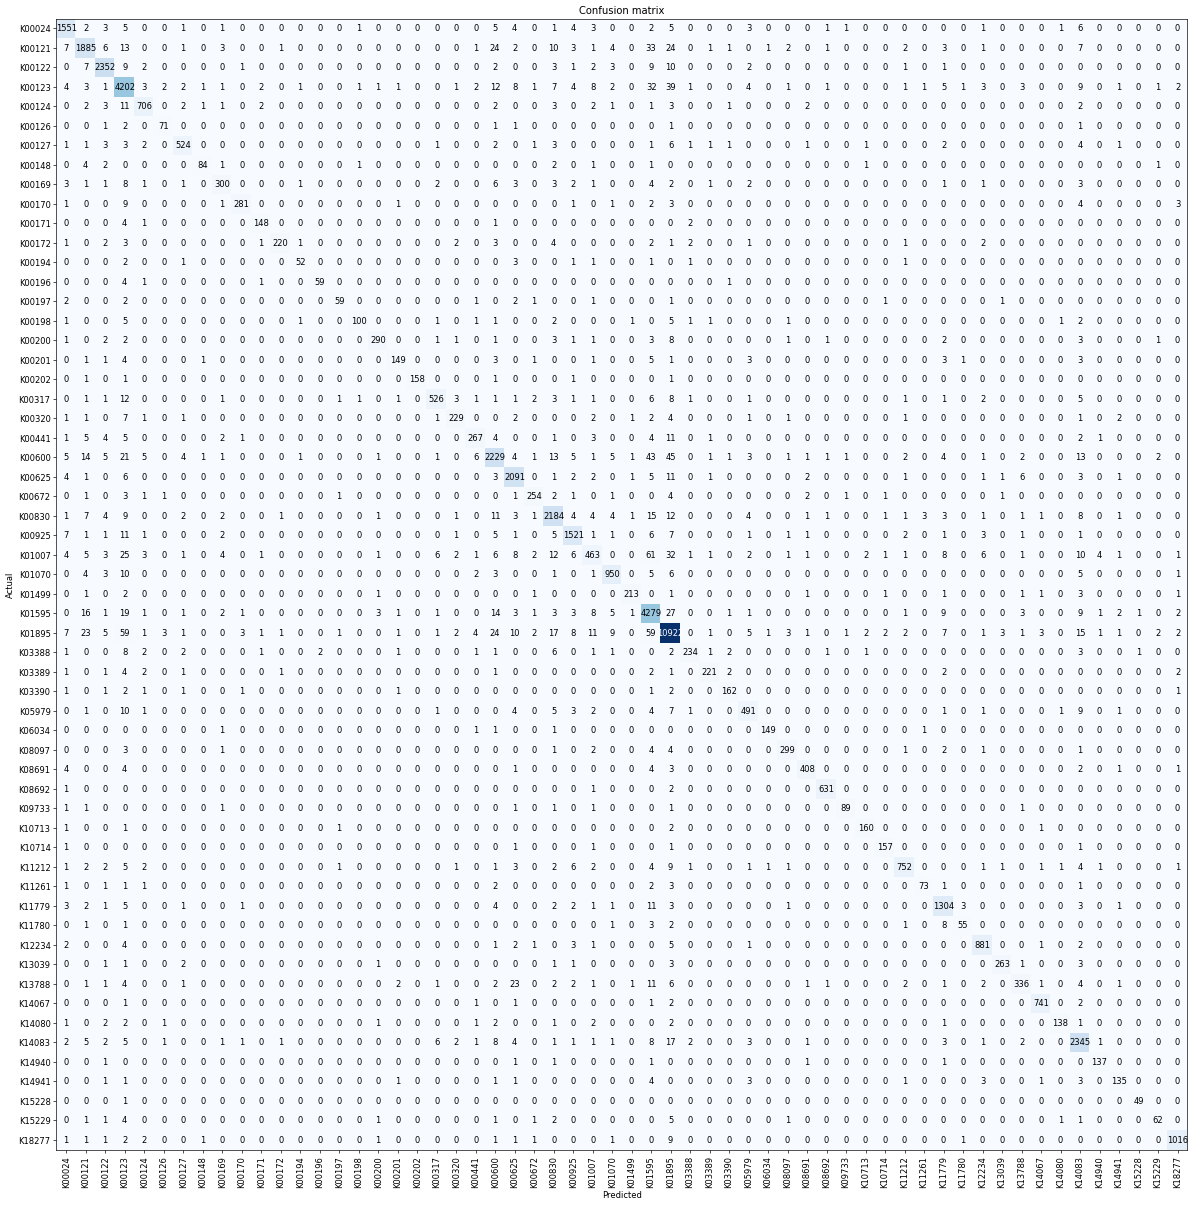

In [58]:
# get the classification matrix
interp = ClassificationInterpretation.from_learner(learn) 
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)
plt.savefig('test_confusion_matrix.pdf',format='pdf')